In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix


# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
#image_size = (224, 224, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/train', transform=transform)
validation_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/val', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/test', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=8)

#validation_set = validation_ds
validation_loader = T.utils.data.DataLoader(validation_set, batch_size=batch_size,shuffle=True, num_workers=8)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True, num_workers=8)

In [3]:
class NewNetwork(nn.Module):
    def __init__(self, num_classes=291):
        super(NewNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 64, kernel_size=1, padding=1),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 64, kernel_size=1, padding=1),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 64, kernel_size=1, padding=1),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.2),
            nn.Conv2d(192, 192, kernel_size=1, padding=1),
            nn.Dropout(p=0.2),
            nn.Conv2d(192, 192, kernel_size=1, padding=1),
            nn.Dropout(p=0.2),
            nn.Conv2d(192, 192, kernel_size=1, padding=1),
            nn.Dropout(p=0.2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3),
            nn.Conv2d(256, 256, kernel_size=1, padding=1),
            nn.Dropout(p=0.3),
            nn.Conv2d(256, 256, kernel_size=1, padding=1),
            nn.Dropout(p=0.3),
            nn.Conv2d(256, 256, kernel_size=1, padding=1),
            nn.Dropout(p=0.3),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(49 * 16 * 16, 4000),
            nn.Dropout(p=0.5),
            nn.Linear(4000, 2000),
            nn.Dropout(p=0.5),
            nn.Linear(2000, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [4]:
net = NewNetwork()
net.to(device)

NewNetwork(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (9): Dropout(p=0.1, inplace=False)
    (10): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.2, inplace=False)
    (14): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (15): Dropout(p=0.2, inplace=False)
    (16): Conv2d(192, 192, kernel_size=(1, 1

In [5]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#dynamic learning rate
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

test_acc = []

lrs = []
steps = []

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in tqdm(range(0, 201)):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    #zone pour mettre le learning rate dynamique
    """
    steps.append(epoch)
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
    """
    
    if epoch % 10 == 0:
        print('\nEpoch: {}'.format(epoch))
    #    print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the validation set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the validation set
    with T.no_grad():
        correct = 0
        total = 0
        validation_running_loss = .0
        for data in validation_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if epoch == 200: # a changer si besoin d'afficher la matrice de confusion, a mettre à epoch-1
                # Append batch prediction results
                predlist=torch.cat([predlist,predicted.view(-1).cpu()])
                lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        validation_running_loss /= len(validation_loader)
        validation_loss.append(validation_running_loss)
        validation_running_acc = correct / total
        validation_acc.append(validation_running_acc)
        
        if epoch % 10 == 0:
            print('validation Acc.  => {:.3f}%'.format(100 * validation_running_acc), end=' | ')
            print('validation Loss  => {:.5f}'.format(validation_running_loss))

    with torch.no_grad():
        correct_t = 0
        total_t = 0
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_t += labels.size(0)
            correct_t += (predicted == labels).sum().item()
            
            running_acc_t = correct_t / total_t
        test_acc.append(running_acc_t)
    
        if epoch % 10 == 0:
            print('Accuracy of the network on test images: %d %%' % (100 * correct_t / total_t))

print('Finished Training')

  0%|          | 0/201 [00:00<?, ?it/s]


Epoch: 0
Train Loss => 5.64949
validation Acc.  => 1.467% | validation Loss  => 5.59643
Accuracy of the network on test images: 1 %

Epoch: 10
Train Loss => 5.46801
validation Acc.  => 1.273% | validation Loss  => 5.45949
Accuracy of the network on test images: 1 %

Epoch: 20
Train Loss => 5.46599
validation Acc.  => 1.451% | validation Loss  => 5.45547
Accuracy of the network on test images: 1 %

Epoch: 30
Train Loss => 5.46514
validation Acc.  => 1.370% | validation Loss  => 5.45430
Accuracy of the network on test images: 1 %

Epoch: 40
Train Loss => 5.46208
validation Acc.  => 1.338% | validation Loss  => 5.45425
Accuracy of the network on test images: 1 %

Epoch: 50
Train Loss => 5.46259
validation Acc.  => 1.386% | validation Loss  => 5.45396
Accuracy of the network on test images: 1 %

Epoch: 60
Train Loss => 5.46178
validation Acc.  => 1.547% | validation Loss  => 5.45254
Accuracy of the network on test images: 1 %

Epoch: 70
Train Loss => 5.46273
validation Acc.  => 1.435% | v

## Visualization

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

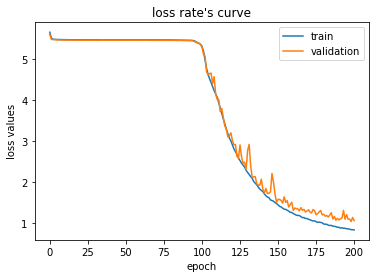

In [8]:
plt.plot(train_loss, label='train')
plt.plot(validation_loss, label='validation')
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.title("loss rate's curve")
plt.legend()
plt.show()

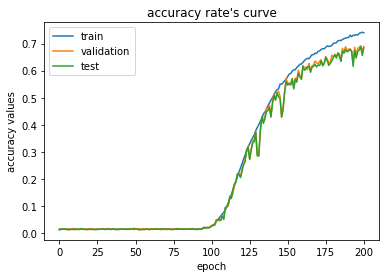

In [9]:
plt.plot(train_acc, label='train')
plt.plot(validation_acc, label='validation')
plt.plot(test_acc, label='test')
plt.xlabel("epoch")
plt.ylabel("accuracy values")
plt.title("accuracy rate's curve")
plt.legend()
plt.show()

In [10]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[13  4  0 ...  0  0  0]
 [ 8 33  0 ...  0  0  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  0 ...  0  0 30]]


<AxesSubplot:>

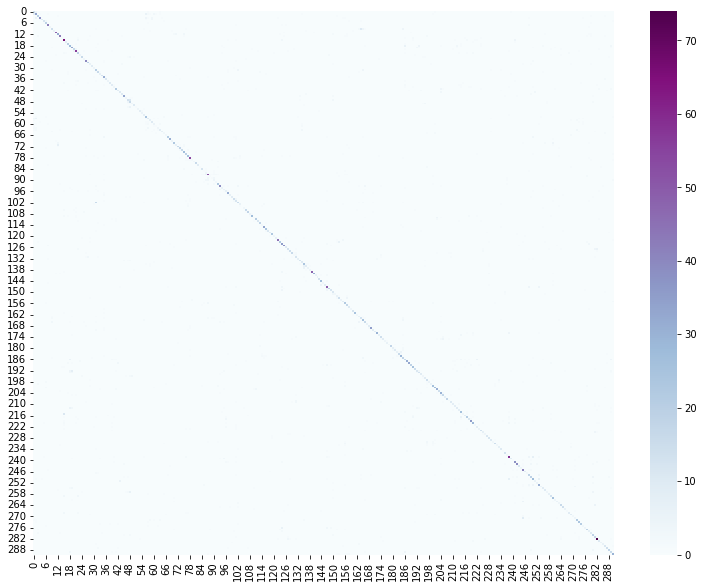

In [11]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(conf_mat, annot=False, ax=ax, cmap="BuPu")

In [12]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[ 61.9047619   55.93220339  83.33333333  66.66666667  62.5
  63.15789474  86.36363636  89.36170213  80.          36.84210526
  60.          94.11764706  68.08510638  76.78571429  11.11111111
  76.74418605  81.81818182  76.92307692  52.83018868  75.
  61.53846154  82.35294118  61.29032258  50.          66.66666667
  57.14285714  85.10638298  95.23809524  42.85714286 100.
  66.66666667  61.76470588  66.66666667  63.63636364  92.85714286
  86.11111111  73.33333333  41.66666667  62.5         50.
  36.36363636  61.11111111  50.          62.5         71.42857143
  82.5         66.66666667  46.42857143  69.56521739  33.33333333
  90.90909091  12.5         50.          72.72727273 100.
  72.72727273  75.75757576  40.          63.63636364  66.66666667
  29.41176471  20.          36.36363636  36.36363636  50.
  33.33333333  50.          61.76470588  93.93939394  83.33333333
  65.71428571  35.          80.          75.          76.19047619
  96.42857143  79.16666667  65.          84.375       18.

## Save

In [13]:
#torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/dict_Linh_network_1st_try")

In [14]:
#torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/Linh_network_entire_model_1st_try")

In [15]:
"""
from torch.utils.data.dataloader import DataLoader


train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

from torchvision.utils import make_grid

def show_batch(dl):
    #Plot images grid of single batch
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

"""

'\nfrom torch.utils.data.dataloader import DataLoader\n\n\ntrain_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\nfrom torchvision.utils import make_grid\n\ndef show_batch(dl):\n    #Plot images grid of single batch\n    for images, labels in dl:\n        fig,ax = plt.subplots(figsize = (16,12))\n        ax.set_xticks([])\n        ax.set_yticks([])\n        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))\n        break\n        \nshow_batch(train_dl)\n\n'

In [16]:
"""
transform2 = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

train_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)

train_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

        
show_batch(train_dl2)
"""

"\ntransform2 = transforms.Compose(\n    [transforms.Resize((224, 224)),\n     transforms.ToTensor()])\n\ntrain_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)\n\ntrain_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)\n\n        \nshow_batch(train_dl2)\n"